# Sktime workshop: Pycon Colombia 2025

![](imgs/sktime-logo.png)

## Agenda for today

1. **Univariate timeseries forecasting with sktime** (30 min)
   1. Key concepts in forecasting
   2. Univariate forecasting with statistical models
   3. Metrics and evaluation
2. **Forecasting panel data with sktime** (30 min)
   1. Data representation for panel data
   2. Up-casting feature in sktime
   3. Panel forecasting with global models and deep learning
3. **Hierarchical forecasting with sktime** (30 min)
   1. Data representation for hierarchical data
   2. Motivation
   3. Hierarchical reconciliation

# 1. Univariate timeseries forecasting with sktime

* Synthetic dataset of sales of a retail store
* We will first consider the case of univariate forecasting
* Suppose  we need to **forecast total sales in a warehouse**  
* **Objective: get familiar with sktime interface and its versatility**

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

warnings.filterwarnings("ignore")

## 1.1. Loading the dataset

We instantiate the dataset and load the training and test sets.

In [2]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset()

y_train, y_test = dataset.load("y_train", "y_test")

display(y_train)

,sales
date,
2020-01-01,90
2020-01-02,108
2020-01-03,111
2020-01-04,97
2020-01-05,82
...,...
2024-07-01,6156
2024-07-02,5501
2024-07-03,5278


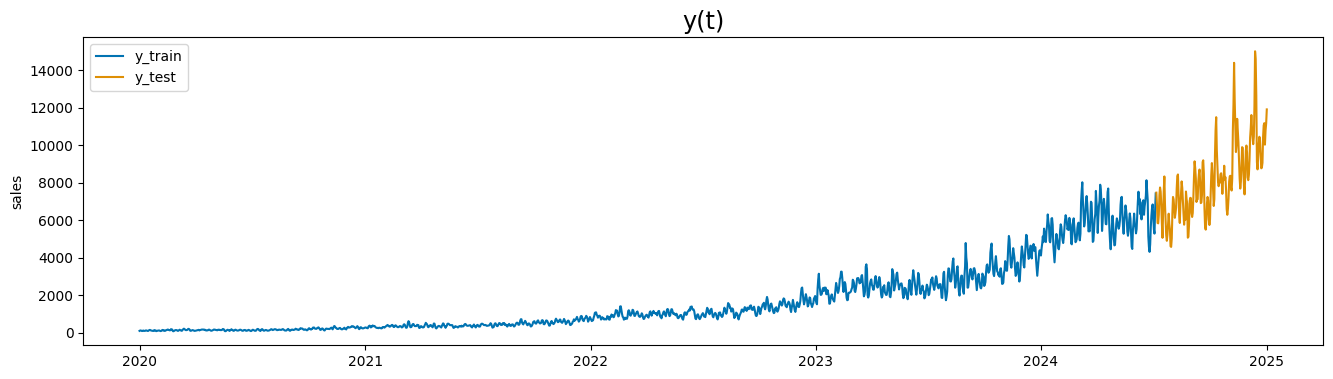

In [8]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, labels=["y_train", "y_test"], title="y(t)", markers=[None]*2)
plt.show()

Timeseries have 3 main components:

1. **Trend**: Long-term movement in the data
2. **Seasonality**: Regular pattern that repeats over time, starting and finishing with predefined frequency.
3. **Noise**: Random variation in the data


Components, such as seasonality, can be *multiplicative* or *additive*, for example:

* **Multiplicative** seasonality implies that every November, there is a 30% increase in the value compared to the average.

    $$
    y(t) = trend(t) * seasonality(t) * noise(t)
    $$

    or, another common model:

    $$
    y(t) = trend(t) + trend*seasonality(t) + noise(t)
    $$

* **Additive** seasonality implies that every November, there is an additional 100 units in the value compared to the average.

    $$
    y(t) = trend(t) + seasonality(t) + noise(t)
    $$


The challenge is obtaining a model that captures these components effectively.

## 1.2. sktime API: from naive to state-of-the-art models


- `fit(y, X=None)`
- `predict(fh=[1,2,3], X=None)`

* `fh` is the forecast horizon, which indicates how many steps ahead we want to predict. 
* `X` is used for exogenous variables, which we will cover later.

**Naive**

Repeat the last observed value or slope. Good baseline.

In [9]:
from sktime.forecasting.naive import NaiveForecaster

model = NaiveForecaster(strategy="drift")
model.fit(y_train)

NaiveForecaster(strategy='drift')

In [10]:
y_pred = model.predict(fh=[1, 2, 3, 4, 5])
y_pred

,sales
2024-07-06,7427.452338
2024-07-07,7431.904675
2024-07-08,7436.357013
2024-07-09,7440.809350
2024-07-10,7445.261688


In [11]:
y_test

,sales
2024-07-06,7463
2024-07-07,6830
2024-07-08,5846
2024-07-09,5825
2024-07-10,6279
...,...
2024-12-28,11169
2024-12-29,10023
2024-12-30,10780
2024-12-31,11158


In [12]:
fh = pd.period_range("2024-10-04", "2025-01-01", freq="D")
y_pred = model.predict(fh=fh)
y_pred

,sales
2024-10-04,7828.162720
2024-10-05,7832.615058
2024-10-06,7837.067395
2024-10-07,7841.519733
2024-10-08,7845.972070
...,...
2024-12-28,8206.611415
2024-12-29,8211.063752
2024-12-30,8215.516090
2024-12-31,8219.968427


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'y_train, y_test and y_pred time series'}, ylabel='sales'>)

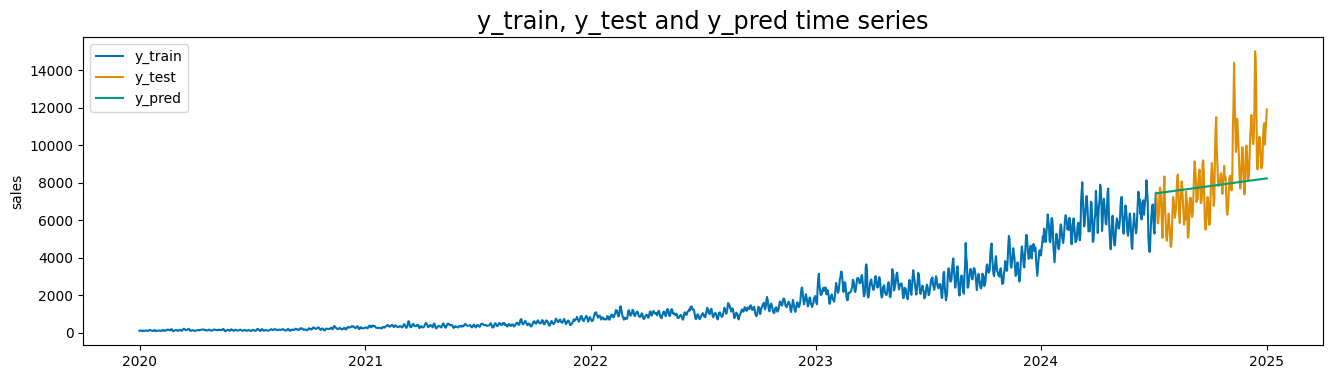

In [13]:
fh = y_test.index
y_pred = model.predict(fh=fh)


plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title="y_train, y_test and y_pred time series",markers=[None]*3)

In [14]:
model.get_params()

{'sp': 1, 'strategy': 'drift', 'window_length': None}

**Exponential smoothing**

* One of the best baselines for forecasting
* Weights past observations exponentially, and optionally include trend and seasonality components

In [40]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

model_exp_smoothing = ExponentialSmoothing(trend="add", seasonal="mul", sp=365, random_state=42)
model_exp_smoothing.fit(y_train)
y_pred_exp_smoothing = model_exp_smoothing.predict(fh=fh)

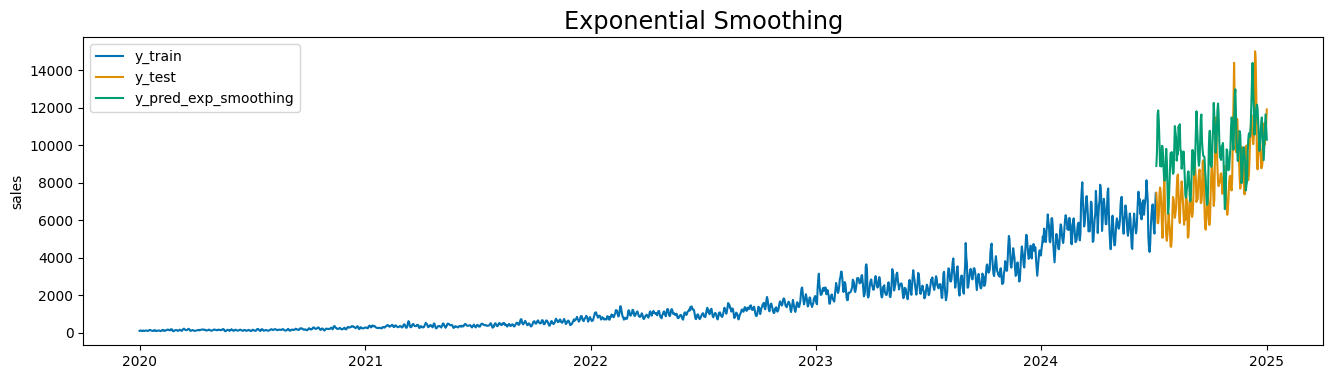

In [41]:
plot_series(y_train, y_test, y_pred_exp_smoothing, labels=["y_train", "y_test", "y_pred_exp_smoothing"], title="Exponential Smoothing", markers=[None]*3)
plt.show()

**Chronos: foundation models for forecasting**

* Almost no code change is required to use more advanced models
* Chronos scales and quantizes the values to forecast, and use a LLM-like architecture to predict the next token
  
![](imgs/chronos.png)

In [42]:
from sktime.forecasting.chronos import ChronosForecaster

chronos = ChronosForecaster("amazon/chronos-t5-tiny")
chronos.fit(y_train)

ChronosForecaster(model_path='amazon/chronos-t5-tiny')

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Chronos tiny'}, ylabel='sales'>)

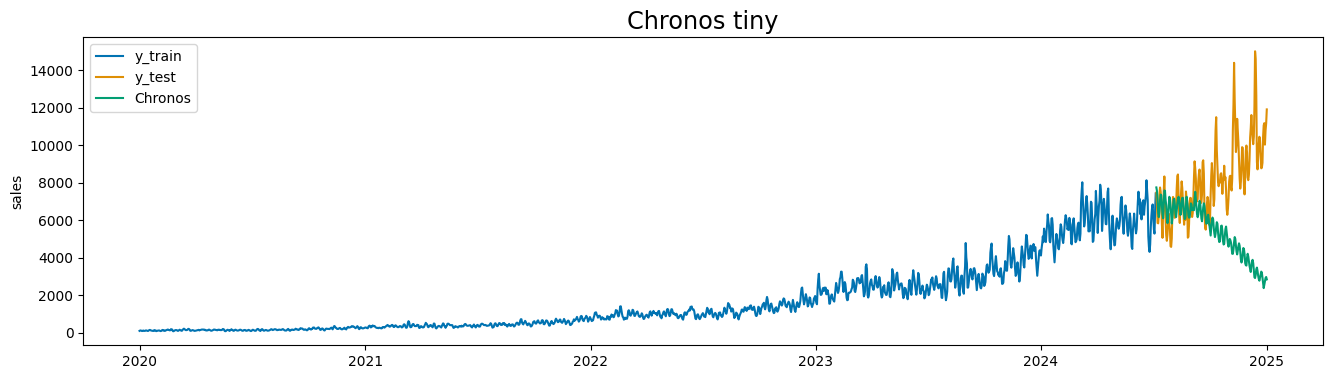

In [ ]:
y_pred_chronos = chronos.predict(fh=y_test.index)

plot_series(y_train, y_test, y_pred_chronos, labels=["y_train", "y_test",  "Chronos"], title="Chronos tiny", markers=[None]*3)
plt.show()

## 1.3. Metrics and Cross-validation

### 1.3.1. Metrics

Qualitative evidence of forecast quality is not enough - we should also investigate it quantitatively

In forecasting, we have several metrics available, each with its own qualities and limitations.
There are some challenges:

* **Scale within a timeseries:** because of the trend, the scale of a timeseries changes overtime, and without taking the scale into account we can penalize some periods more than others
* **Scale accross timeseries:** different timeseries can have different scales, and 
* **Zeros**: to solve the scale problem, some metrics compute the percentage error. However, how to use it when the denominator is zero?


Some proposals:

* Scale the original metric, such as Mean Squared Error, by the error of a naive model
* Also scale the metric by the forecast itself (symmetric MAPE for example)

Still, every metric has its own problems, and the most important thing is to align it with the users of the forecast.

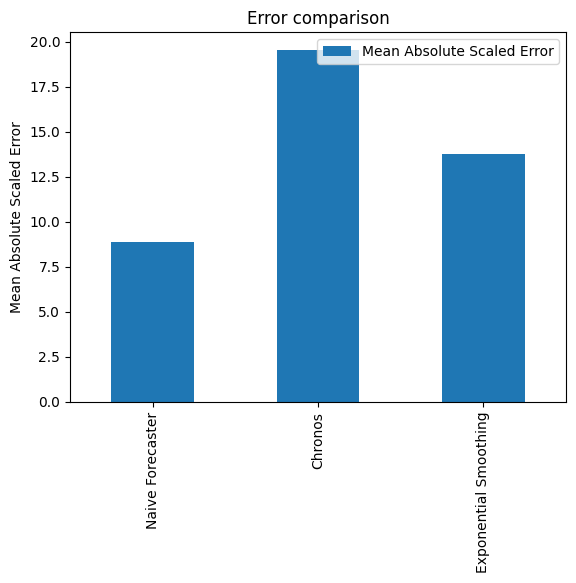

In [ ]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
    MeanAbsoluteScaledError,
)


metric = MeanAbsoluteScaledError()
error_baseline = metric(y_true=y_test, y_pred=y_pred, y_train=y_train)
error_chronos = metric(y_true=y_test, y_pred=y_pred_chronos, y_train=y_train)
error_exp_smoothing = metric(
    y_true=y_test, y_pred=y_pred_exp_smoothing, y_train=y_train
)

errors = pd.DataFrame(
    {
        "Naive Forecaster": error_baseline,
        "Chronos": error_chronos,
        "Exponential Smoothing": error_exp_smoothing,
    },
    index=["Mean Absolute Scaled Error"],
)

errors.T.plot.bar(title="Error comparison", ylabel="Mean Absolute Scaled Error")
plt.show()

### 1.3.2. Cross-validation with sktime

To evaluate the performance of a model, cross-validation (a.k.a backtesting) is a must!

* **The accuracy of a single split is conditioned on the cutoff!** Also, has large variance.
* The performance can change depending on the day of the year

We can use one of the many strategies in `sktime.split`.

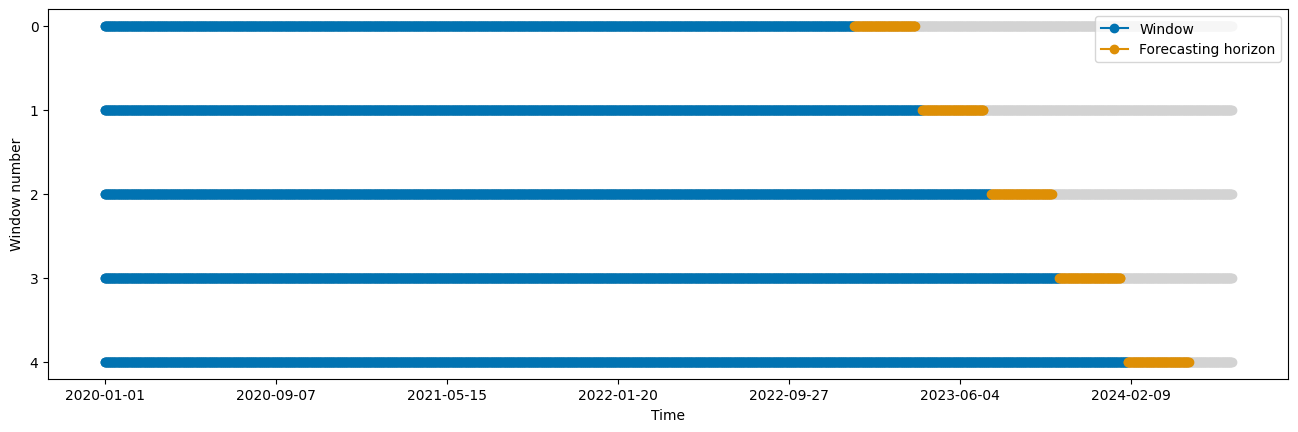

In [45]:
from sktime.split import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

expanding_window_cv = ExpandingWindowSplitter(
    initial_window=365*3, step_length=100, fh=list(range(1, 90+1))
)
plot_windows(cv=expanding_window_cv, y=y_train)
plt.show()

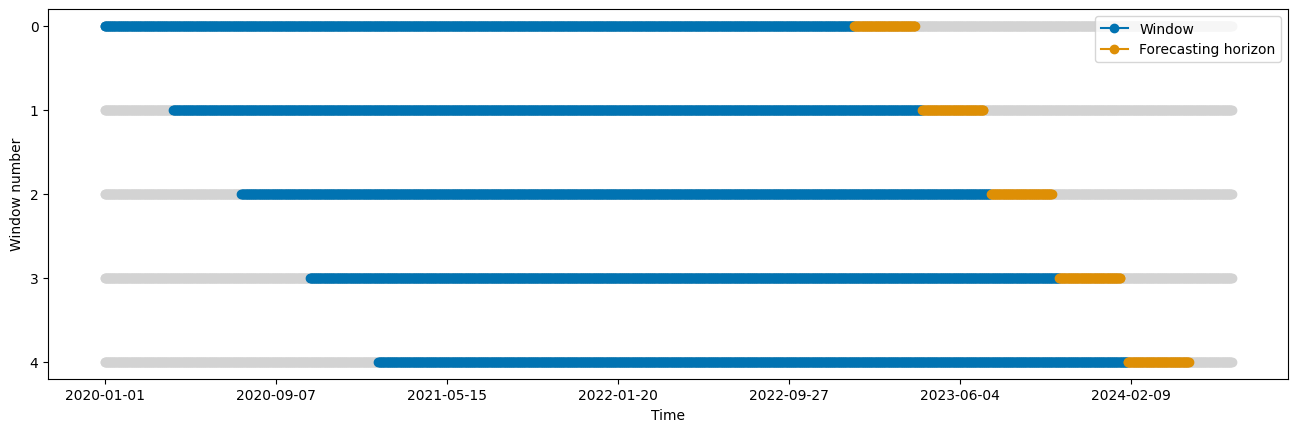

In [46]:
from sktime.split import SlidingWindowSplitter
sliding_window_cv = SlidingWindowSplitter(
    window_length=365*3, step_length=100, fh=list(range(1, 90+1))
)
plot_windows(cv=sliding_window_cv, y=y_train)
plt.show()

In [47]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

evaluate(
    forecaster=model,
    cv=expanding_window_cv,
    y=y_train,
    X=None,
    scoring=MeanAbsoluteScaledError(),
    error_score="raise",
    return_data=True,
)

,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,8.394505,0.002529,0.002100,1095,2022-12-30,sales 2020-01-01 90 2020-01-02...,sales 2022-12-31 1949 2023-01-01...,sales 2022-12-31 1871.62705...
1,8.072613,0.002371,0.002088,1195,2023-04-09,sales 2020-01-01 90 2020-01-02...,sales 2023-04-10 2547 2023-04-11...,sales 2023-04-10 2838.29983...
2,7.075186,0.002567,0.002070,1295,2023-07-18,sales 2020-01-01 90 2020-01-02...,sales 2023-07-19 2357 2023-07-20...,sales 2023-07-19 2435.81143...
3,11.780463,0.002534,0.001880,1395,2023-10-26,sales 2020-01-01 90 2020-01-02...,sales 2023-10-27 3374 2023-10-28...,sales 2023-10-27 2981.07245...
4,5.841538,0.002221,0.001740,1495,2024-02-03,sales 2020-01-01 90 2020-01-02...,sales 2024-02-04 5211 2024-02-05...,sales 2024-02-04 5657.72423...


## 1.4. Hyperparameter tuning

* The cross-validation should reflect as most as possible the true training process that we use in production. 
* If, every execution date, we tune the hyperparameters, hyperparameter tuning is itself part of the model strategy and should be backtested!

In [48]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

ExponentialSmoothing().get_params()

{'damped_trend': False,
 'damping_trend': None,
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'method': None,
 'minimize_kwargs': None,
 'optimized': True,
 'random_state': None,
 'remove_bias': False,
 'seasonal': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_trend': None,
 'sp': None,
 'start_params': None,
 'trend': None,
 'use_boxcox': None,
 'use_brute': True}

In [49]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SingleWindowSplitter

cv_tuning = SingleWindowSplitter(fh=list(range(1, 180 + 1)),window_length=365*2)

tuner = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(sp=365),
    param_grid={
        "trend": [
            "add",
            "mul",
        ],
        "seasonal" : [
            "add",
            "mul"
        ],
    },
    cv=cv_tuning,
    scoring=MeanAbsoluteScaledError(),
    error_score="raise",
)

tuner.fit(y_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ForecastingGridSearchCV(cv=SingleWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29, 30, ...],
                                                window_length=730),
                        error_score='raise',
                        forecaster=ExponentialSmoothing(sp=365),
                        param_grid={'seasonal': ['add', 'mul'],
                                    'trend': ['add', 'mul']},
                        scoring=MeanAbsoluteScaledError())

In [50]:
tuner.best_params_

{'seasonal': 'add', 'trend': 'mul'}

In [51]:
tuner.best_forecaster_

ExponentialSmoothing(seasonal='add', sp=365, trend='mul')

In [52]:
evaluate(
    forecaster=tuner,
    cv=expanding_window_cv,
    y=y_train,
    X=None,
    scoring=MeanAbsoluteScaledError(),
    error_score="raise",
    return_data=True,
)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodel

,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,5.759162,8.830292,0.009241,1095,2022-12-30,sales 2020-01-01 90 2020-01-02...,sales 2022-12-31 1949 2023-01-01...,sales 2022-12-31 1903.96935...
1,4.535557,9.904021,0.009206,1195,2023-04-09,sales 2020-01-01 90 2020-01-02...,sales 2023-04-10 2547 2023-04-11...,sales 2023-04-10 2569.11761...
2,6.688774,10.938632,0.013505,1295,2023-07-18,sales 2020-01-01 90 2020-01-02...,sales 2023-07-19 2357 2023-07-20...,sales 2023-07-19 2423.63837...
3,6.150866,10.437920,0.010093,1395,2023-10-26,sales 2020-01-01 90 2020-01-02...,sales 2023-10-27 3374 2023-10-28...,sales 2023-10-27 3108.81329...
4,34.434459,9.191036,0.010272,1495,2024-02-03,sales 2020-01-01 90 2020-01-02...,sales 2024-02-04 5211 2024-02-05...,sales 2024-02-04 5717.602...


## 1.5. Transformations

* Some forecasters need preprocessing to work better with specific datasets
* We can also use them of Exploratory Data Analysis
* Example: Logarithmic transformation, Differencing, Decomposition...
* Some transformations on `y` - we could same most of them - require transforming and then inverse-transforming.

$$
\hat{y}(t) = f^{-1}(\,m(\,f(y(t-1))\,)\,) = (f^{-1} \circ m \circ f)(y(t-1))
$$

$$

m \rightarrow f^{-1} \circ m \circ f
$$

**Interface:**

* `fit(X, y)` (optional): fit parameters related to the transformation
* `transform(X, y)` : transform a given `X` 
* `inverse_transform(X, y)` (optional): inverse transform

Note that in transformations we can swap `X` with `y`, as follows.

 


### 1.4.1. Timeseries differencing

* Differencing helps eliminating the trend: useful when models are not able to capture it
* However, it can increase noise

![](imgs/difference_animation.gif)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Differenced time series'}, ylabel='sales'>)

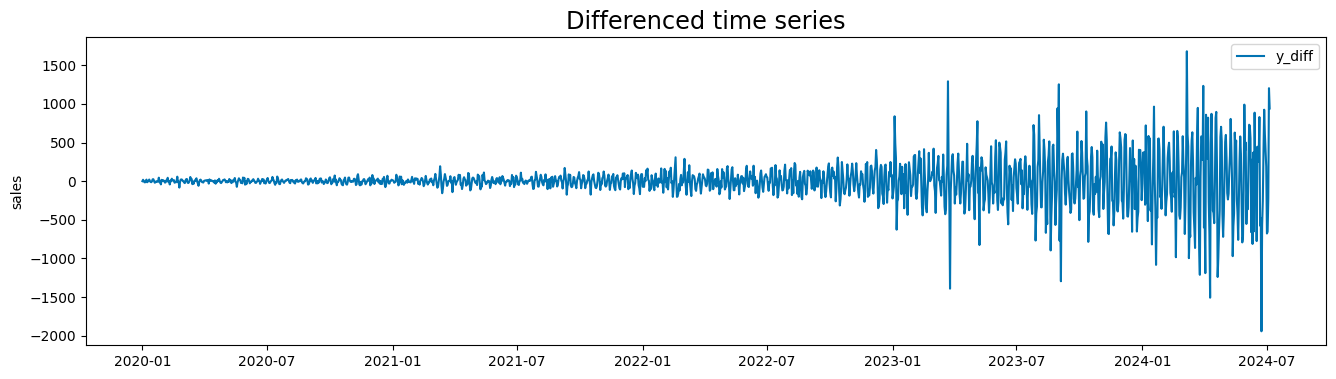

In [ ]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer()
transformer.fit(y_train)
y_diff = transformer.transform(y_train)

plot_series(y_diff, labels=["y_diff"], title="Differenced time series", markers=[None])
plt.show()

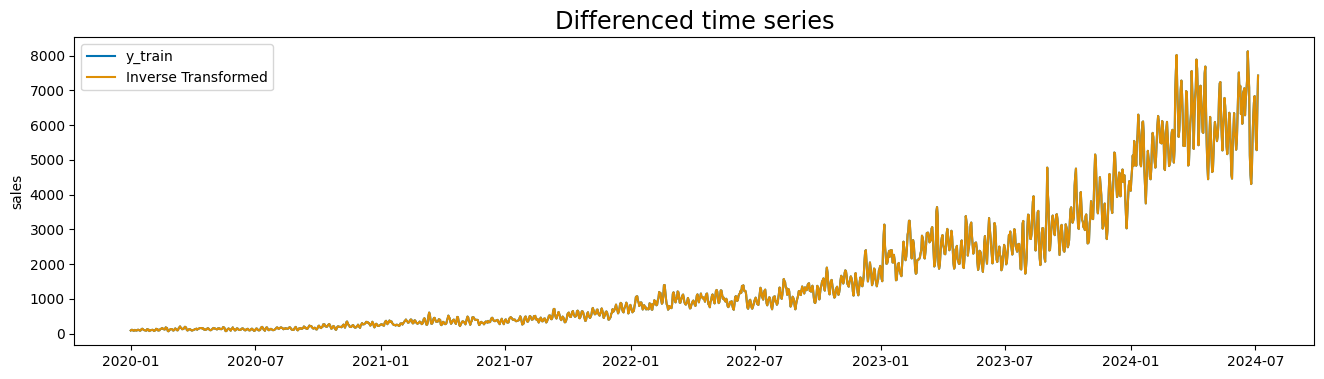

In [54]:
y_diff_inv = transformer.inverse_transform(y_diff)
plot_series(y_train, y_diff_inv, labels=["y_train", "Inverse Transformed"], title="Differenced time series", markers=[None]*2)
plt.show()

### 1.4.2. Detrending

* Remove the trend with a smoothing model
* Useful when we do not want to use differencing because of noise, but the trend is easy to capture

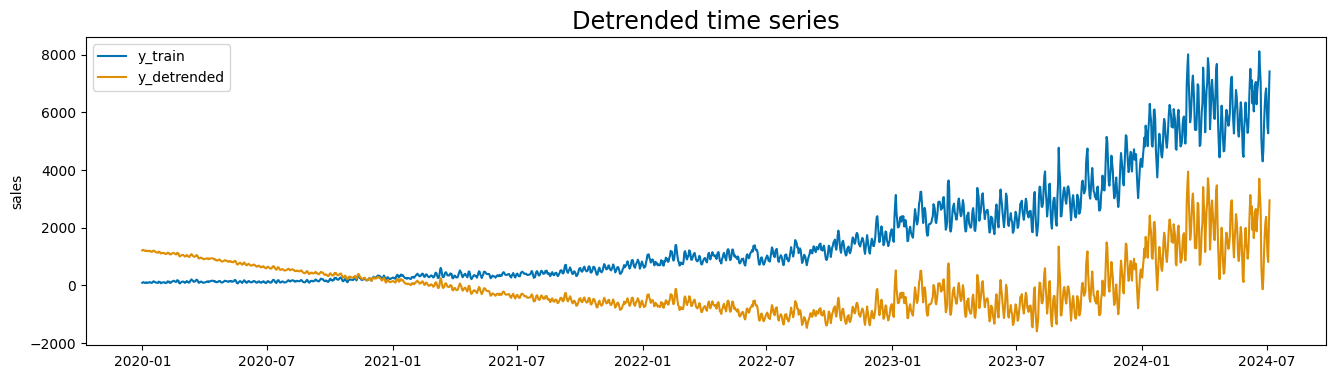

In [93]:
from sktime.transformations.series.detrend import Detrender, Deseasonalizer


transformer = Detrender()
transformer.fit(y_train)

y_detrended = transformer.transform(y_train)


plot_series(y_train, y_detrended, labels=["y_train", "y_detrended"], title="Detrended time series", markers=[None]*2)
plt.show()


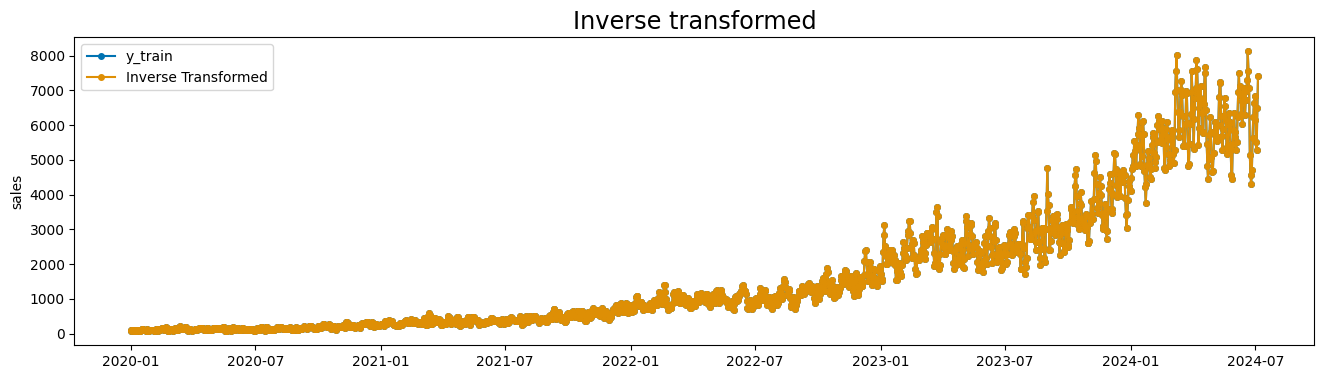

In [94]:
y_detrended_inv = transformer.inverse_transform(y_detrended)

plot_series(y_train, y_detrended_inv, labels=["y_train", "Inverse Transformed"], title="Inverse transformed")
plt.show()

Using transformations for `y` with models is easy! You can simply use `TransformedTargetForecaster`, or use the operator `*`.

In [57]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.auto_reg import AutoREG
from sktime.transformations.series.boxcox import LogTransformer

pipeline = TransformedTargetForecaster(
    steps=[
        ("log", LogTransformer()),
        ("differencer", Differencer()),
        ("forecaster", AutoREG()),
    ]
)

Equivalently...

In [58]:
pipeline = LogTransformer() * Differencer() * AutoREG()

pipeline.fit(y_train)
y_pred_pipeline = pipeline.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Transformed Target Forecaster'}, ylabel='sales'>)

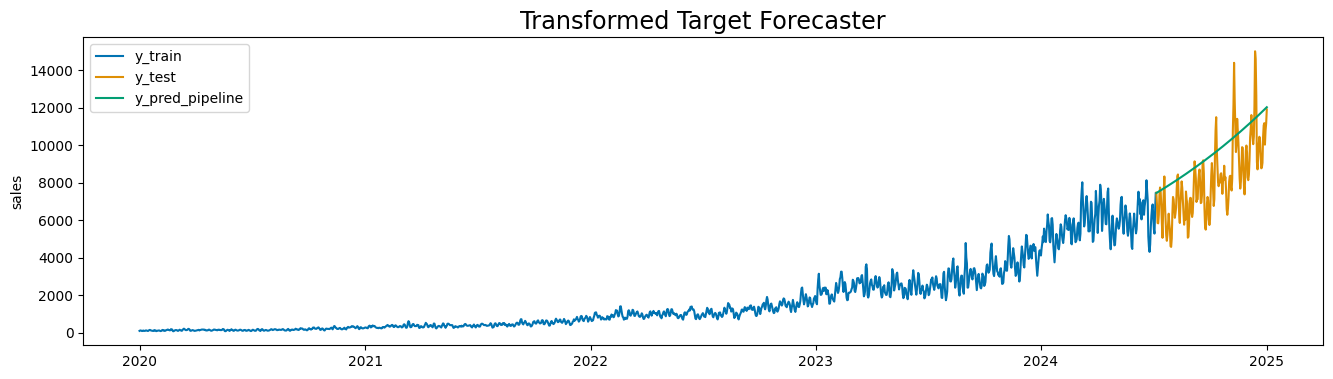

In [59]:
plot_series(
    y_train, y_test, y_pred_pipeline,
    labels=["y_train", "y_test", "y_pred_pipeline"],
    title="Transformed Target Forecaster",
    markers=[None]*3
)

### 1.4.3. Decomposition

* STL is a classical decomposition model
* Allows decomposition of trend, seasonality and the remainder
* Accounts seasonality that changes overtime

In [61]:
from sktime.transformations.series.detrend import STLTransformer

transformer = STLTransformer(sp=365, return_components=True)
transformer.fit(y_train)

STLTransformer(return_components=True, sp=365)

In [62]:
y_decomposed = transformer.transform(y_train)
y_decomposed

,transformed,seasonal,trend,resid
2020-01-01,101.136333,-11.136333,129.670298,-28.533965
2020-01-02,82.930106,25.069894,129.931774,-47.001669
2020-01-03,96.248042,14.751958,130.193724,-33.945681
2020-01-04,114.213622,-17.213622,130.456149,-16.242526
2020-01-05,217.863651,-135.863651,130.719051,87.144600
...,...,...,...,...
2024-07-01,6398.018016,-242.018016,6234.133356,163.884660
2024-07-02,6322.120044,-821.120044,6243.536760,78.583284
2024-07-03,6243.632788,-965.632788,6252.941560,-9.308772
2024-07-04,6524.537433,-42.537433,6262.347748,262.189686


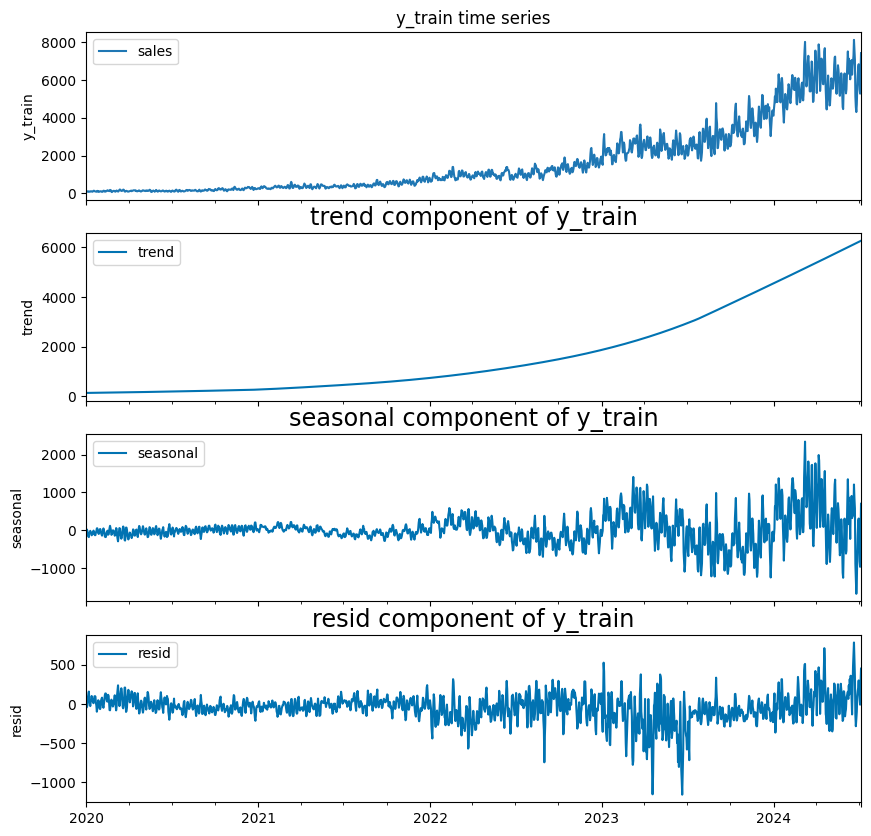

In [63]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 10), sharex=True)

y_train.plot(ax=axs[0], title="y_train time series")
axs[0].set_ylabel("y_train")
axs[0].set_xlabel("date")
for i, component in enumerate(["trend", "seasonal", "resid"]):
    plot_series(y_decomposed[component], labels=[component], title=f"{component} component of y_train", markers=[None], ax=axs[i+1])
fig.show()


* Key components during fit
  * `y`: target variable
  * `X`: features (optional)
  * `fh`: forecasting horizon (optional)
* Key components during predict
  * `fh`: forecasting horizon (optional)
  * `X`: features (optional)
  

## 1.6. Forecasting with exogenous data

Timeseries can optionally have exogenous data, that help the model capturing behaviours that are not easy to capture only with the target variable.

In [83]:
X_train, X_test = dataset.load("X_train", "X_test")
X_train

,promo
date,
2020-01-01,0.0
2020-01-02,0.0
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0
...,...
2024-07-01,1.0
2024-07-02,0.0
2024-07-03,0.0


The tag system allows us to identify which forecasters support exogenous data.

In [84]:
from sktime.registry import all_estimators

all_estimators("forecaster", filter_tags={"ignores-exogeneous-X": False}, as_dataframe=True).head(10)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,AutoREG,<class 'sktime.forecasting.auto_reg.AutoREG'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,BoxCoxBiasAdjustedForecaster,<class 'sktime.forecasting.boxcox_bias_adjuste...
7,CINNForecaster,<class 'sktime.forecasting.conditional_inverti...
8,ChronosForecaster,<class 'sktime.forecasting.chronos.ChronosFore...
9,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...


The interface is the same as before, but we can pass `X` to the `fit` and `predict` methods.

In [95]:
from sktime.forecasting.auto_reg import AutoREG

model_exog =  Differencer() * AutoREG(seasonal=True, period=365)
model_exog.fit(y_train, X=X_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   AutoREG(period=365, seasonal=True)])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'AutoREG with exogenous variables'}, ylabel='sales'>)

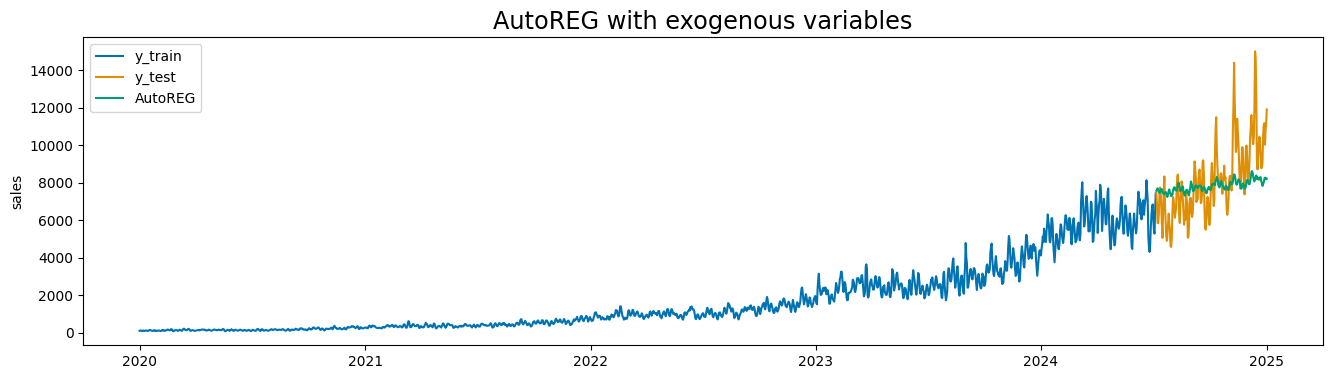

In [97]:
y_pred_exog = model_exog.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred_exog, labels=["y_train", "y_test", "AutoREG"], title="AutoREG with exogenous variables", markers=[None]*3)

### 1.6.1. Transformations with exogenous data

We can of course also apply transformations to the exogenous data!

* Usually, we do not use the same transformations as for `y`, but we can use the same interface.
* In this case, we do not need to inverse-transform the exogenous data, as it is not used in the final forecast.

Common applications:

* Standarization
* Feature selection
* Adding new features, such as Fourier features

**Question:** how would you add features for weekly seasonality to your model?


* Option 1: dummies.
* Option 2: ...


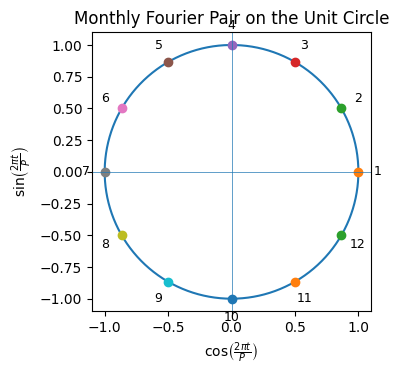

In [108]:
import numpy as np

# Unit circle
theta = np.linspace(0, 2 * np.pi, 1000)

plt.figure(figsize=(4, 4))
plt.plot(np.cos(theta), np.sin(theta))  # circle outline

for month in range(12):
    angle = 2 * np.pi * month / 12
    x, y = np.cos(angle), np.sin(angle)
    plt.plot(x, y, marker="o")
    plt.text(
        1.15 * x, 1.15 * y, f"{month + 1}", ha="center", va="center", fontsize=9
    )

plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel(r"$\cos\!\left(\frac{2\pi t}{P}\right)$")
plt.ylabel(r"$\sin\!\left(\frac{2\pi t}{P}\right)$")
plt.title("Monthly Fourier Pair on the Unit Circle")
plt.tight_layout()
plt.show()

In [ ]:
from sktime.transformations.series.fourier import FourierFeatures

fourier_features = FourierFeatures(sp_list=[365.25, 365.25/12, 7], fourier_terms_list=[4,2, 2], freq="D")

In [99]:
fourier_features.fit_transform(X_train).head()

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4,sin_30.4375_1,cos_30.4375_1,sin_30.4375_2,cos_30.4375_2,sin_7_1,cos_7_1,sin_7_2,cos_7_2
date,,,,,,,,,,,,,,,,
2020-01-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2020-01-02,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.204966,0.978769,0.401229,0.915978,0.781831,0.623490,0.974928,-0.222521
2020-01-03,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.401229,0.915978,0.735034,0.678031,0.974928,-0.222521,-0.433884,-0.900969
2020-01-04,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.580455,0.814292,0.945320,0.326144,0.433884,-0.900969,-0.781831,0.623490
2020-01-05,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.735034,0.678031,0.996751,-0.080549,-0.433884,-0.900969,0.781831,0.623490


### 1.6.2. Pipeline with exogenous data transformations

In [100]:
from sktime.forecasting.compose import ForecastingPipeline

forecaster = LogTransformer() * Differencer() * AutoREG()
pipeline_exog = ForecastingPipeline(
    steps=[
        ("fourier", fourier_features),
        ("forecaster", forecaster)
    ]
)

equivalently... we can use the operator `**`. 

- `*` is used for target transformations
- `**` is used for exogenous transformations

In [101]:
pipeline_exog = fourier_features ** (LogTransformer() * Differencer() * AutoREG() )

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Transformed Target Forecaster'}, ylabel='sales'>)

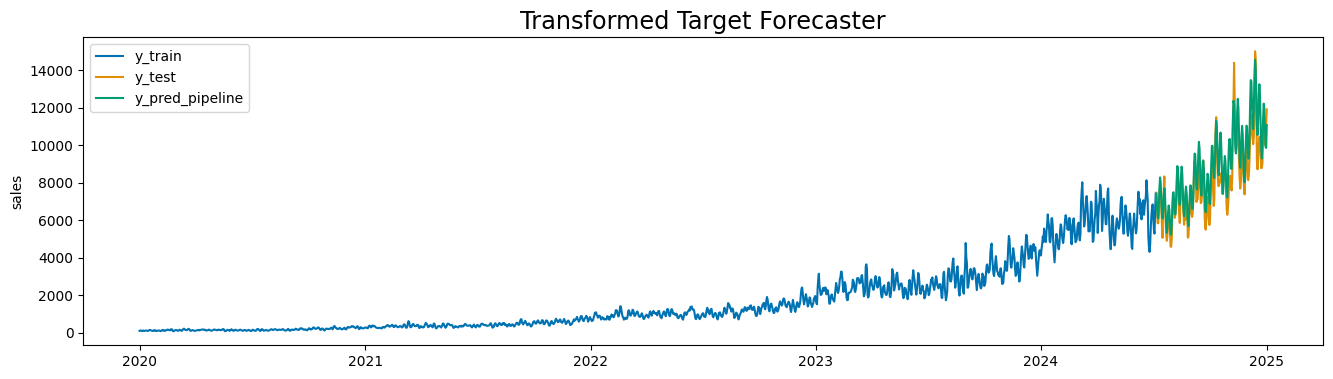

In [102]:

pipeline_exog.fit(y_train, X=X_train)
y_pred_fourier = pipeline_exog.predict(fh=fh, X=X_test)

plot_series(
    y_train, y_test, y_pred_fourier,
    labels=["y_train", "y_test", "y_pred_pipeline"],
    title="Transformed Target Forecaster",
    markers=[None]*3
)

In [103]:
pipeline_exog.get_params()

{'steps': [FourierFeatures(fourier_terms_list=[4, 2, 2], freq='D',
                  sp_list=[365.25, 30.4375, 7]),
  TransformedTargetForecaster(steps=[LogTransformer(), Differencer(), AutoREG()])],
 'FourierFeatures': FourierFeatures(fourier_terms_list=[4, 2, 2], freq='D',
                 sp_list=[365.25, 30.4375, 7]),
 'TransformedTargetForecaster': TransformedTargetForecaster(steps=[LogTransformer(), Differencer(), AutoREG()]),
 'FourierFeatures__fourier_terms_list': [4, 2, 2],
 'FourierFeatures__freq': 'D',
 'FourierFeatures__keep_original_columns': False,
 'FourierFeatures__sp_list': [365.25, 30.4375, 7],
 'TransformedTargetForecaster__steps': [LogTransformer(),
  Differencer(),
  AutoREG()],
 'TransformedTargetForecaster__LogTransformer': LogTransformer(),
 'TransformedTargetForecaster__Differencer': Differencer(),
 'TransformedTargetForecaster__AutoREG': AutoREG(),
 'TransformedTargetForecaster__LogTransformer__offset': 0,
 'TransformedTargetForecaster__LogTransformer__scale':

## Extra: advanced patterns, such as ensemble

In [106]:
from sktime.forecasting.compose import EnsembleForecaster, AutoEnsembleForecaster


model_ensemble = AutoEnsembleForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="drift")),
        ("exp_smoothing", ExponentialSmoothing(trend="add", seasonal="mul", sp=365)),
        ("chronos",Differencer() *  ChronosForecaster("amazon/chronos-t5-tiny")),
        ("autoregression",Differencer() *  AutoREG(seasonal=True, period=365)),
    ]
)

model_ensemble.fit(y_train, X=X_train)

AutoEnsembleForecaster(forecasters=[('naive',
                                     NaiveForecaster(strategy='drift')),
                                    ('exp_smoothing',
                                     ExponentialSmoothing(seasonal='mul',
                                                          sp=365,
                                                          trend='add')),
                                    ('chronos',
                                     TransformedTargetForecaster(steps=[Differencer(),
                                                                        ChronosForecaster(model_path='amazon/chronos-t5-tiny')])),
                                    ('autoregression',
                                     TransformedTargetForecaster(steps=[Differencer(),
                                                                        AutoREG(period=365,
                                                                                seasonal=True)]))])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Ensemble of Forecasters'}, ylabel='sales'>)

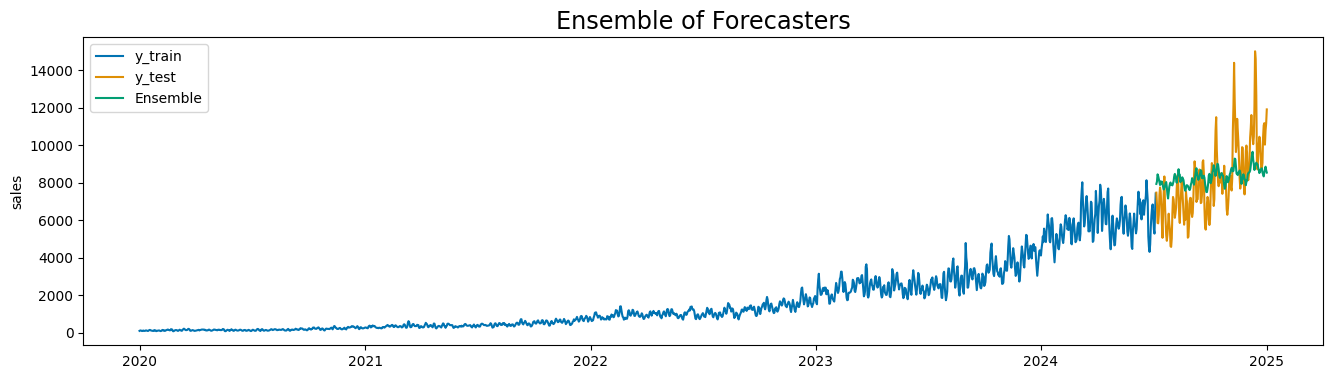

In [105]:
y_pred_ensemble = model_ensemble.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred_ensemble, labels=["y_train", "y_test", "Ensemble"], title="Ensemble of Forecasters", markers=[None]*3)

## Next steps

* Fit and predict multiple timeseries
* Use Machine Learning regression models for forecasting